# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^4, < Delta_tau > = pi, K = 1, eta M^2 = 0.01
# nonlinear run: N0 = 1, eqmean = 0
# Test sensitivity of results to turbulent functions
## set F1, G1, N1 = 0 separately

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'35'}

## Physical Parameters

In [2]:
# eta * Ma ^2 = 0.01
Ma = 0.01 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [3]:
meandeltaT = np.pi

# variables for generating F2, H, and G1
stdF2 = eta * Ma**2
limitY2 = eta 
eqmean = 0

## Calculation parameters

In [4]:
L = 1
M = 10**4
M_short = 100
N = 1
m = 10**2

J = 100
dTau= 2 * np.pi / J

Tr = K * meandeltaT

Tmax = 2 * np.pi * M

## Initial Conditions

In [5]:
initial_AT = 0
initial_dAdT = 0

### Functions

In [6]:
def fundeltaT(n_bins, M, dTau):
    Tturb = [0]
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
            
        deltaT.append(deltaTtemp2[0])
        Tturb.append(deltaTtemp2 + Tturb[i])
        
    Tturb.pop(-1)
    Tturb.pop(-1)
    return deltaT, Tturb

### F_k Function

In [62]:
# generating F2, G1
def funF_k(std, limit, deltaT, eqmean):
    F_k =[]
    y1 = 0
    
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k

# generating F1
def fundHdt(std, limit, deltaT, eqmean):
    dHdt =[]
    y1 = 0

    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                # calculated the derivative of H = 16 * y1 * x**2 * (1 - x)**2
                dHdt.append(1 / deltaT[i] * 32 * y1 * x * (2 * x**2 - 3 * x + 1))
        
    return dHdt

def funNLAmp(F1, F2, G1, dTau, A, dAdt, N0, N1):
    # huen's method
    # u = dA/dt
    
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = dAdt
    
    for i in range(0, int(len(F1))-2):
        m1 = u
        k1 = - (F1[i] * u ) - ( 1 + G1[i] ) * A  - (N0 + N1[i]) * A**2 + F2[i]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -(F1[i + 1] * u_2 ) - ( 1 + G1[i + 1] ) * A_2 - (N0 + N1[i+1]) * A_2**2 + F2[i + 1]
        m2 = u + dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)
        if math.isnan(A):
            break
        

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    
    return Amp, amptime

def funShort(Amp, AmpF1, AmpG1, AmpN1, amptime):
    A = []
    AF1 = []
    AG1 = []
    AN1 = []
    time = []
    
    for i in range(1, len(Amp)-1):
       
        time.append(amptime[i])
        A.append(Amp[i])
        AF1.append(AmpF1[i])
        AG1.append(AmpG1[i])
        AN1.append(AmpN1[i])
        
        # add values until blow out
        if math.isnan(Amp[i+1]) or abs(Amp[i+1]) > 1:
            break
    return time, A, AF1, AG1, AN1

In [66]:
def FunplotAmp(time, Amp, AmpF1, AmpG1, AmpN1):
    fig, axs = plt.subplots(4, 1, figsize=(40,30))
    fig.subplots_adjust(hspace=0) 

    # Plot each graph
    axs[0].plot(time, Amp, 'k', label = "normal turbulent functions")
    axs[0].set_ylabel('A', **axis_font)
    axs[0].set_ylim(-.8, .8)
    axs[0].tick_params(axis = 'y', labelsize = 20)
    axs[0].legend(fontsize = 25, loc = "upper center")

    axs[1].plot(time, AmpF1, 'k', label = "F1 = 0")
    axs[1].set_ylabel('A', **axis_font)
    axs[1].set_ylim(-0.8, 0.8)
    axs[1].tick_params(axis = 'y', labelsize = 20)
    axs[1].legend(fontsize = 25, loc = "upper center")
    
    axs[2].plot(time, AmpG1, 'k', label = "G1 = 0")
    axs[2].set_ylabel('A', **axis_font)
    axs[2].set_ylim(-0.8, 0.8)
    axs[2].tick_params(axis = 'y', labelsize = 20)
    axs[2].legend(fontsize = 25, loc = "upper center")
    
    axs[3].plot(time, AmpN1, 'k', label = "N1 = 0")
    axs[3].set_ylabel('A', **axis_font)
    axs[3].set_ylim(-0.8, 0.8)
    axs[3].set_xlabel('T', **axis_font)
    axs[3].tick_params(axis = 'both', labelsize = 20)
    axs[3].legend(fontsize = 25, loc = "upper center")
    
    plt.show()

# Run 1

In [9]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1, N1
F1 = fundHdt(stdF2, limitY2, deltaT, eqmean)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean)
G1 = funF_k(stdF2, limitY2, deltaT, eqmean)
N1 = funF_k(stdF2, limitY2, deltaT, eqmean)

zero = [0 for i in range(len(N1))]

In [10]:
N0 = 1

# normal turbulent functions
Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# F1 = 0
AmpF1, amptimeF1 = funNLAmp(zero, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# G1 = 0
AmpG1, amptimeG1 = funNLAmp(F1, F2, zero, dTau, initial_AT, initial_dAdT, N0, N1)
# N1 = 0
AmpN1, amptimeN1 = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, zero)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
print("Blow out time for each run")
print("Normal turbulent functions: T = ", amptime[-1])
print("F1 = 0: T = ", amptimeF1[-1])
print("G1 = 0: T = ", amptimeG1[-1])
print("N1 = 0: T = ", amptimeN1[-1])

Blow out time for each run
Normal turbulent functions: T =  11635.705206689528
F1 = 0: T =  7244.952482139221
G1 = 0: T =  14525.279297643787
N1 = 0: T =  26554.249072827413


### Before F1 = 0 blowout

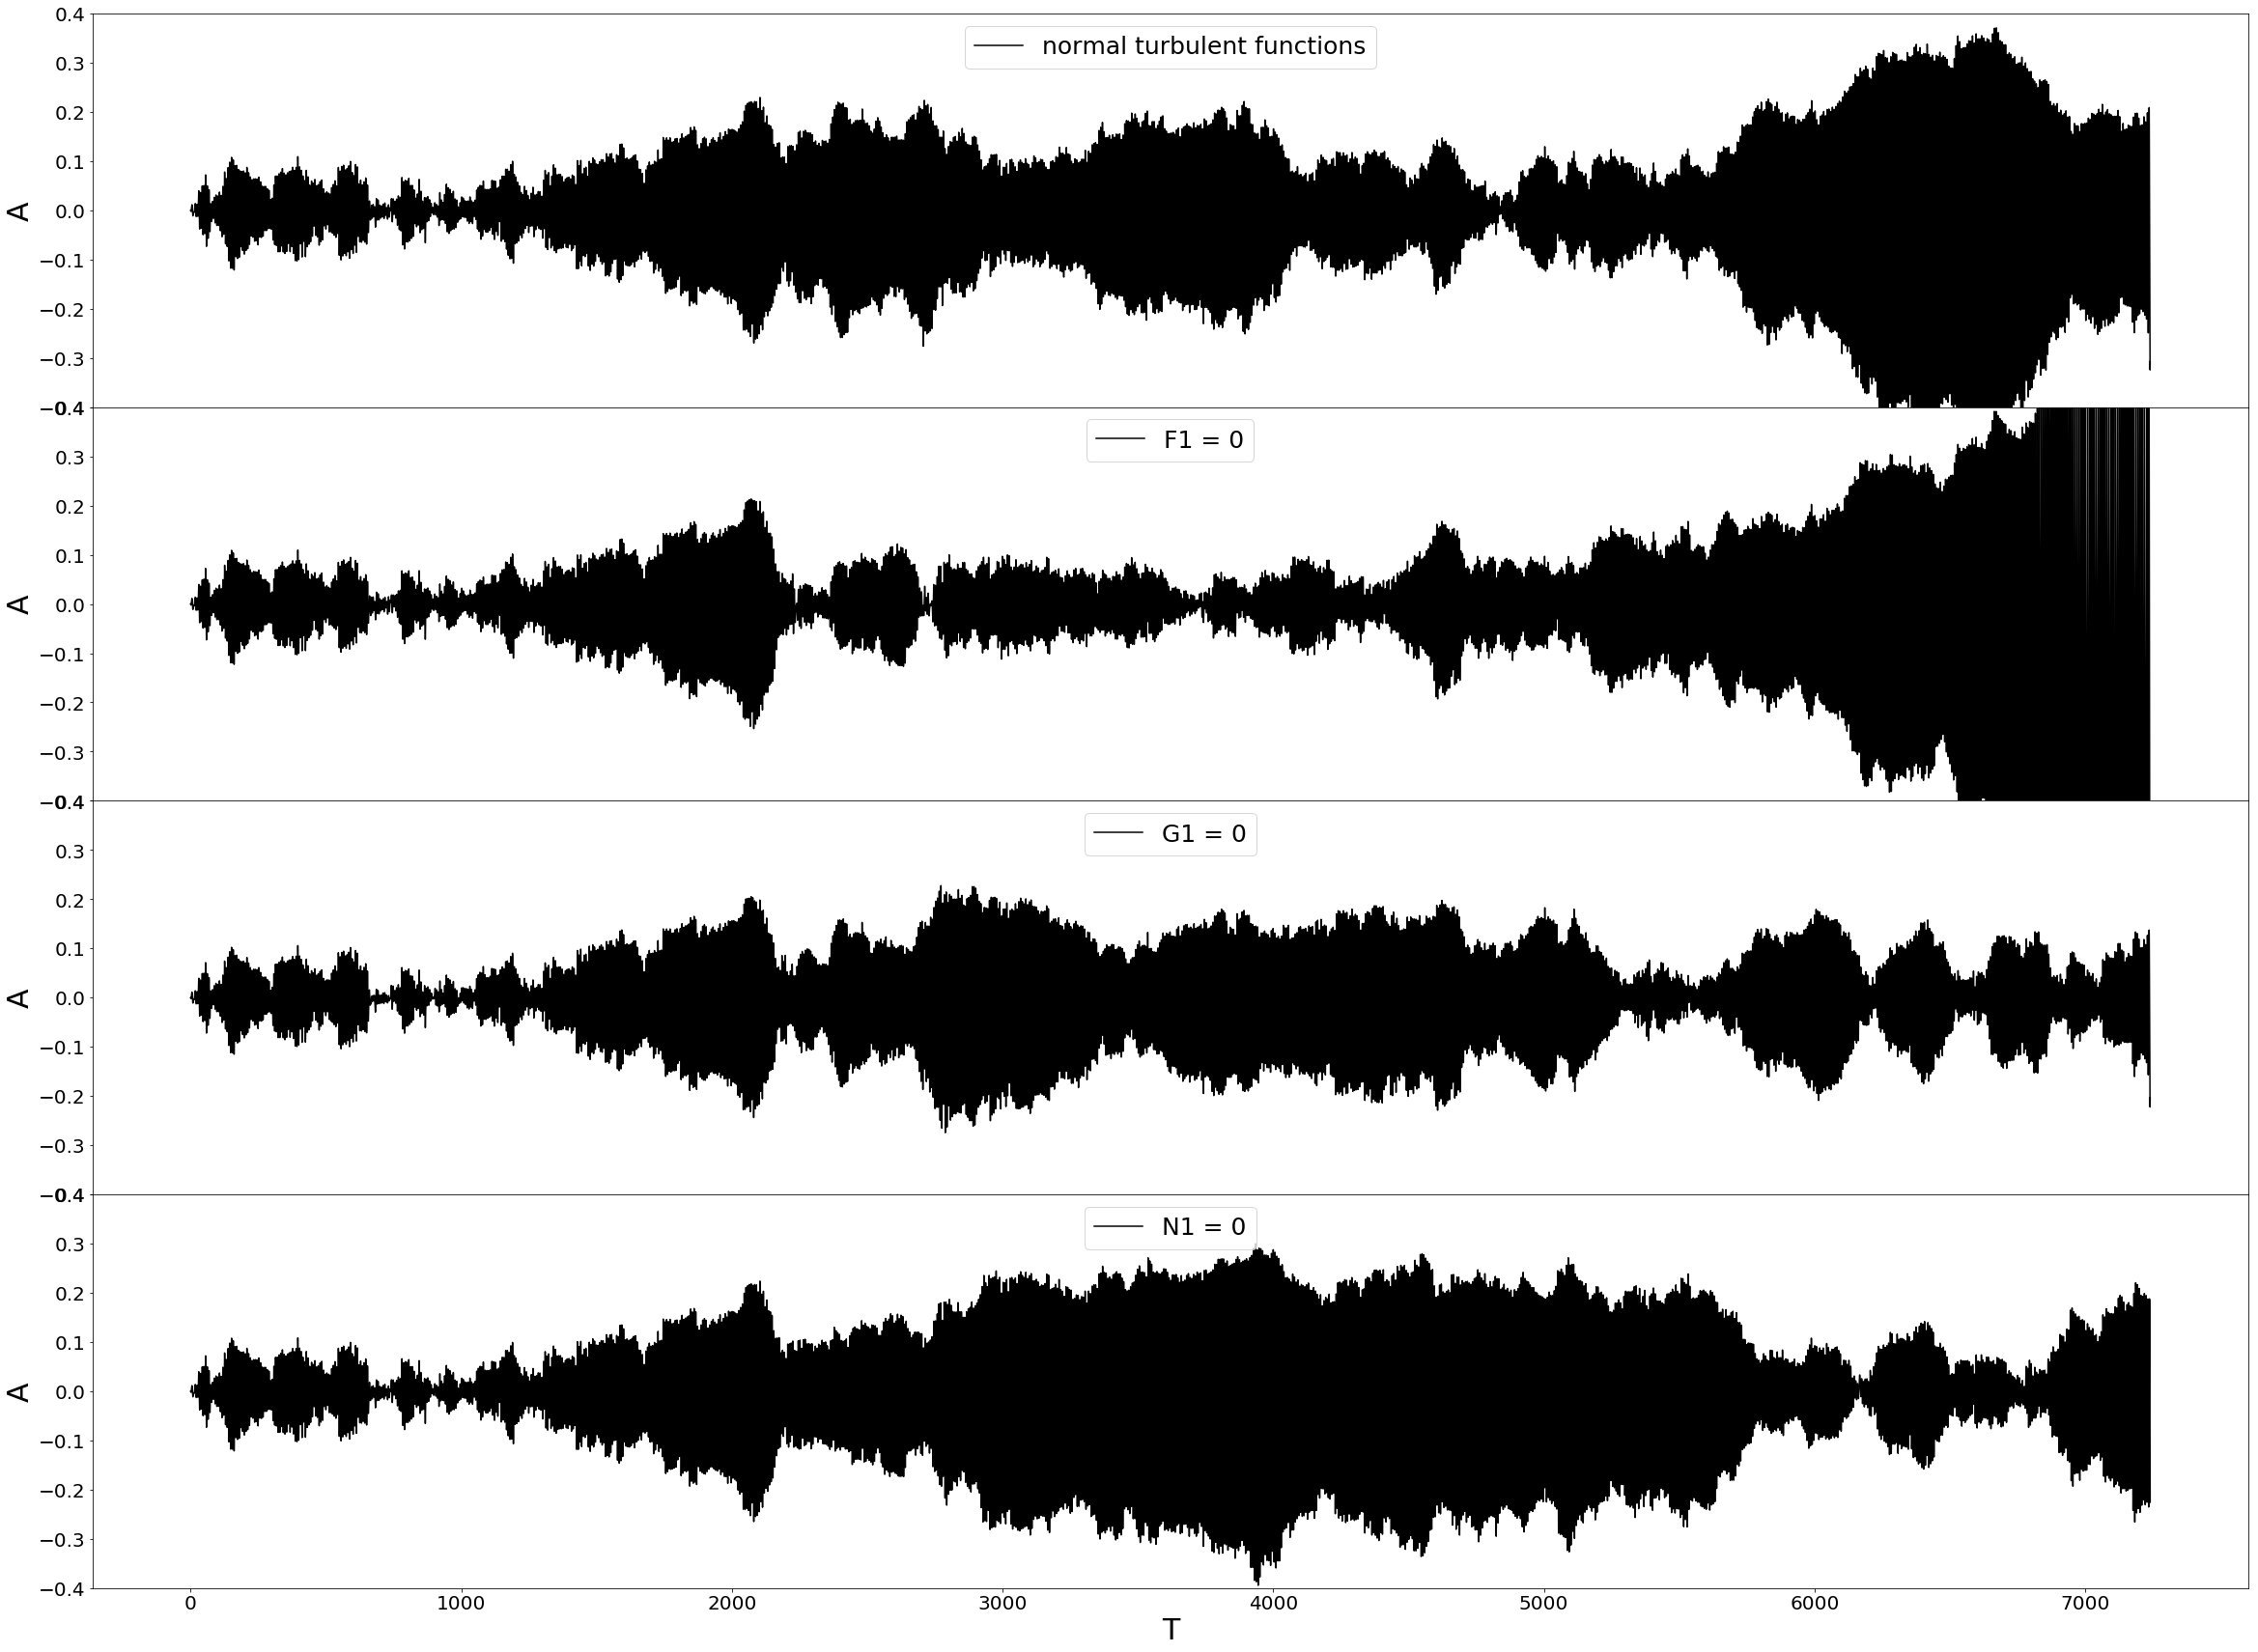

In [21]:
time, A, AF1, AG1, AN1 = funShort(Amp, AmpF1, AmpG1, AmpN1, amptime)
FunplotAmp(time, A, AF1, AG1, AN1)

# Run 2

In [22]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1, N1
F1 = fundHdt(stdF2, limitY2, deltaT, eqmean)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean)
G1 = funF_k(stdF2, limitY2, deltaT, eqmean)
N1 = funF_k(stdF2, limitY2, deltaT, eqmean)

zero = [0 for i in range(len(N1))]

In [23]:
N0 = 1

# normal turbulent functions
Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# F1 = 0
AmpF1, amptimeF1 = funNLAmp(zero, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# G1 = 0
AmpG1, amptimeG1 = funNLAmp(F1, F2, zero, dTau, initial_AT, initial_dAdT, N0, N1)
# N1 = 0
AmpN1, amptimeN1 = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, zero)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


In [24]:
print("Blow out time for each run")
print("Normal turbulent functions: T = ", amptime[-1])
print("F1 = 0: T = ", amptimeF1[-1])
print("G1 = 0: T = ", amptimeG1[-1])
print("N1 = 0: T = ", amptimeN1[-1])

Blow out time for each run
Normal turbulent functions: T =  8258.116112920647
F1 = 0: T =  17602.469301872727
G1 = 0: T =  17105.5321759218
N1 = 0: T =  5714.619868725944


### Before N1 = 0 blowout

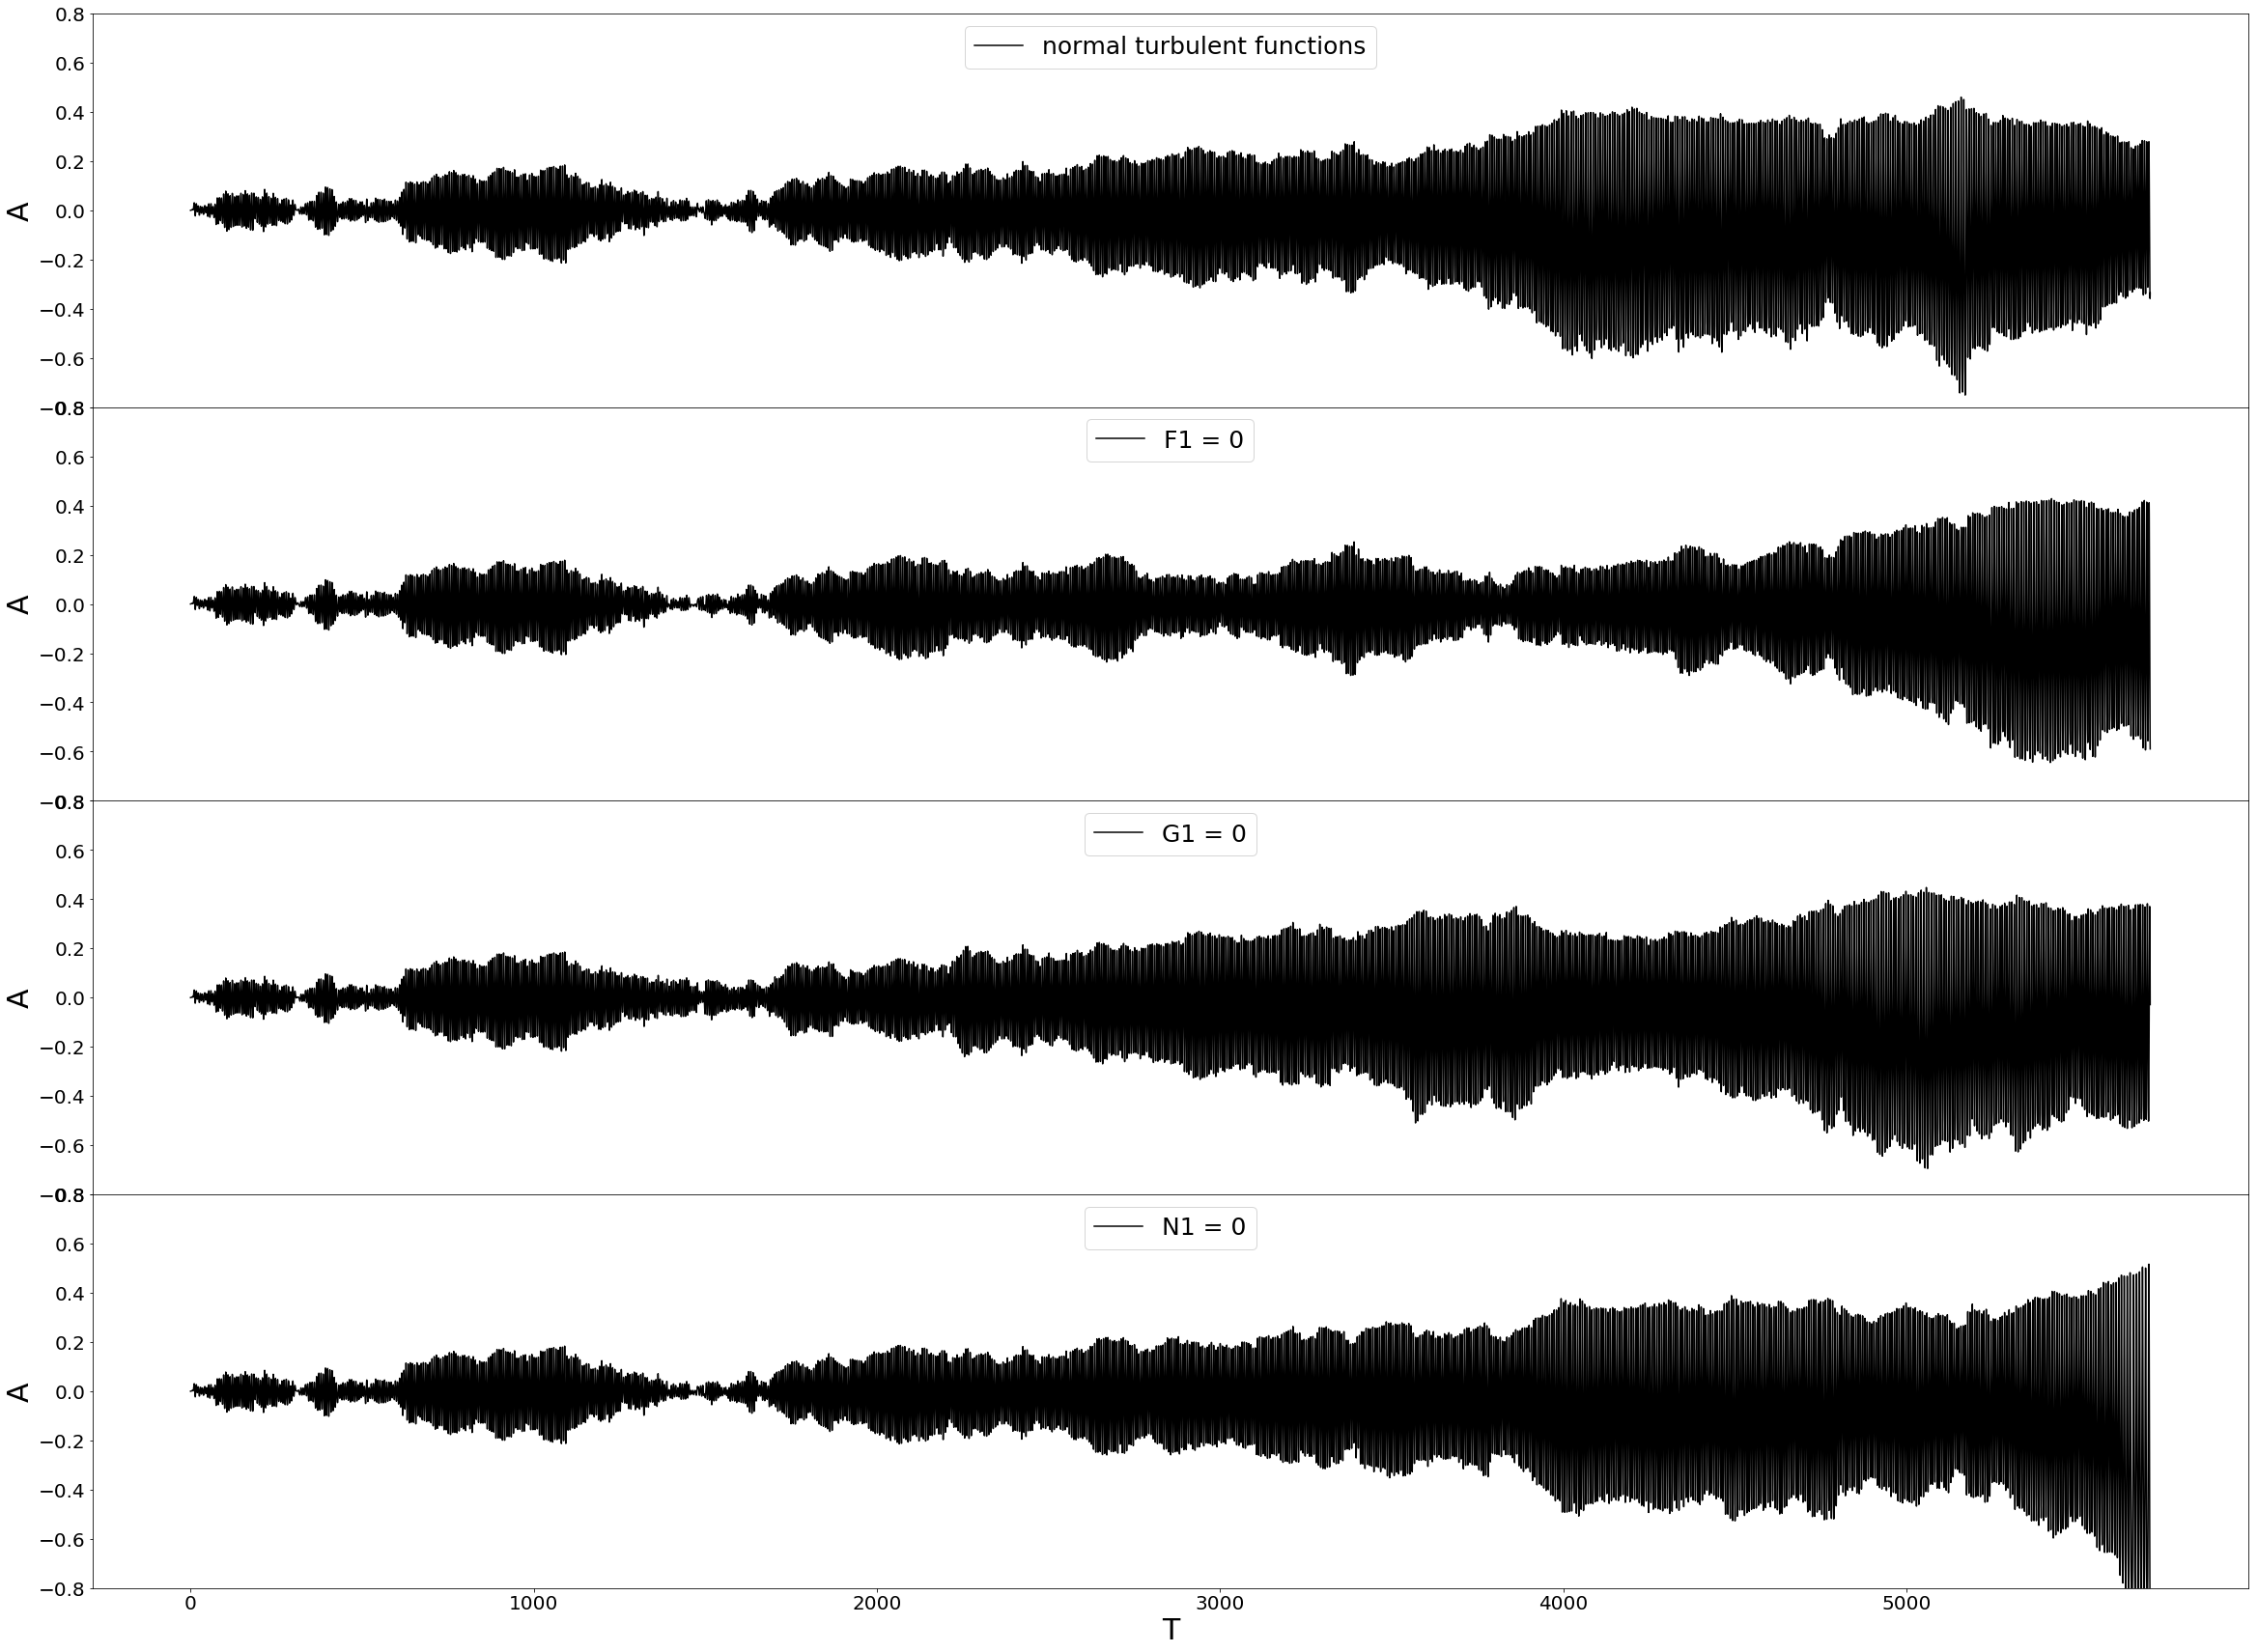

In [30]:
time, A, AF1, AG1, AN1 = funShort(Amp, AmpF1, AmpG1, AmpN1, amptime)
FunplotAmp(time, A, AF1, AG1, AN1)

# Run 3

In [37]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1, N1
F1 = fundHdt(stdF2, limitY2, deltaT, eqmean)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean)
G1 = funF_k(stdF2, limitY2, deltaT, eqmean)
N1 = funF_k(stdF2, limitY2, deltaT, eqmean)

zero = [0 for i in range(len(N1))]

In [38]:
N0 = 1

# normal turbulent functions
Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# F1 = 0
AmpF1, amptimeF1 = funNLAmp(zero, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# G1 = 0
AmpG1, amptimeG1 = funNLAmp(F1, F2, zero, dTau, initial_AT, initial_dAdT, N0, N1)
# N1 = 0
AmpN1, amptimeN1 = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, zero)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


In [39]:
print("Blow out time for each run")
print("Normal turbulent functions: T = ", amptime[-1])
print("F1 = 0: T = ", amptimeF1[-1])
print("G1 = 0: T = ", amptimeG1[-1])
print("N1 = 0: T = ", amptimeN1[-1])

Blow out time for each run
Normal turbulent functions: T =  12012.759156978
F1 = 0: T =  7841.101104083102
G1 = 0: T =  2948.384705393175
N1 = 0: T =  8821.906330540785


### Before G1 = 0 blowout

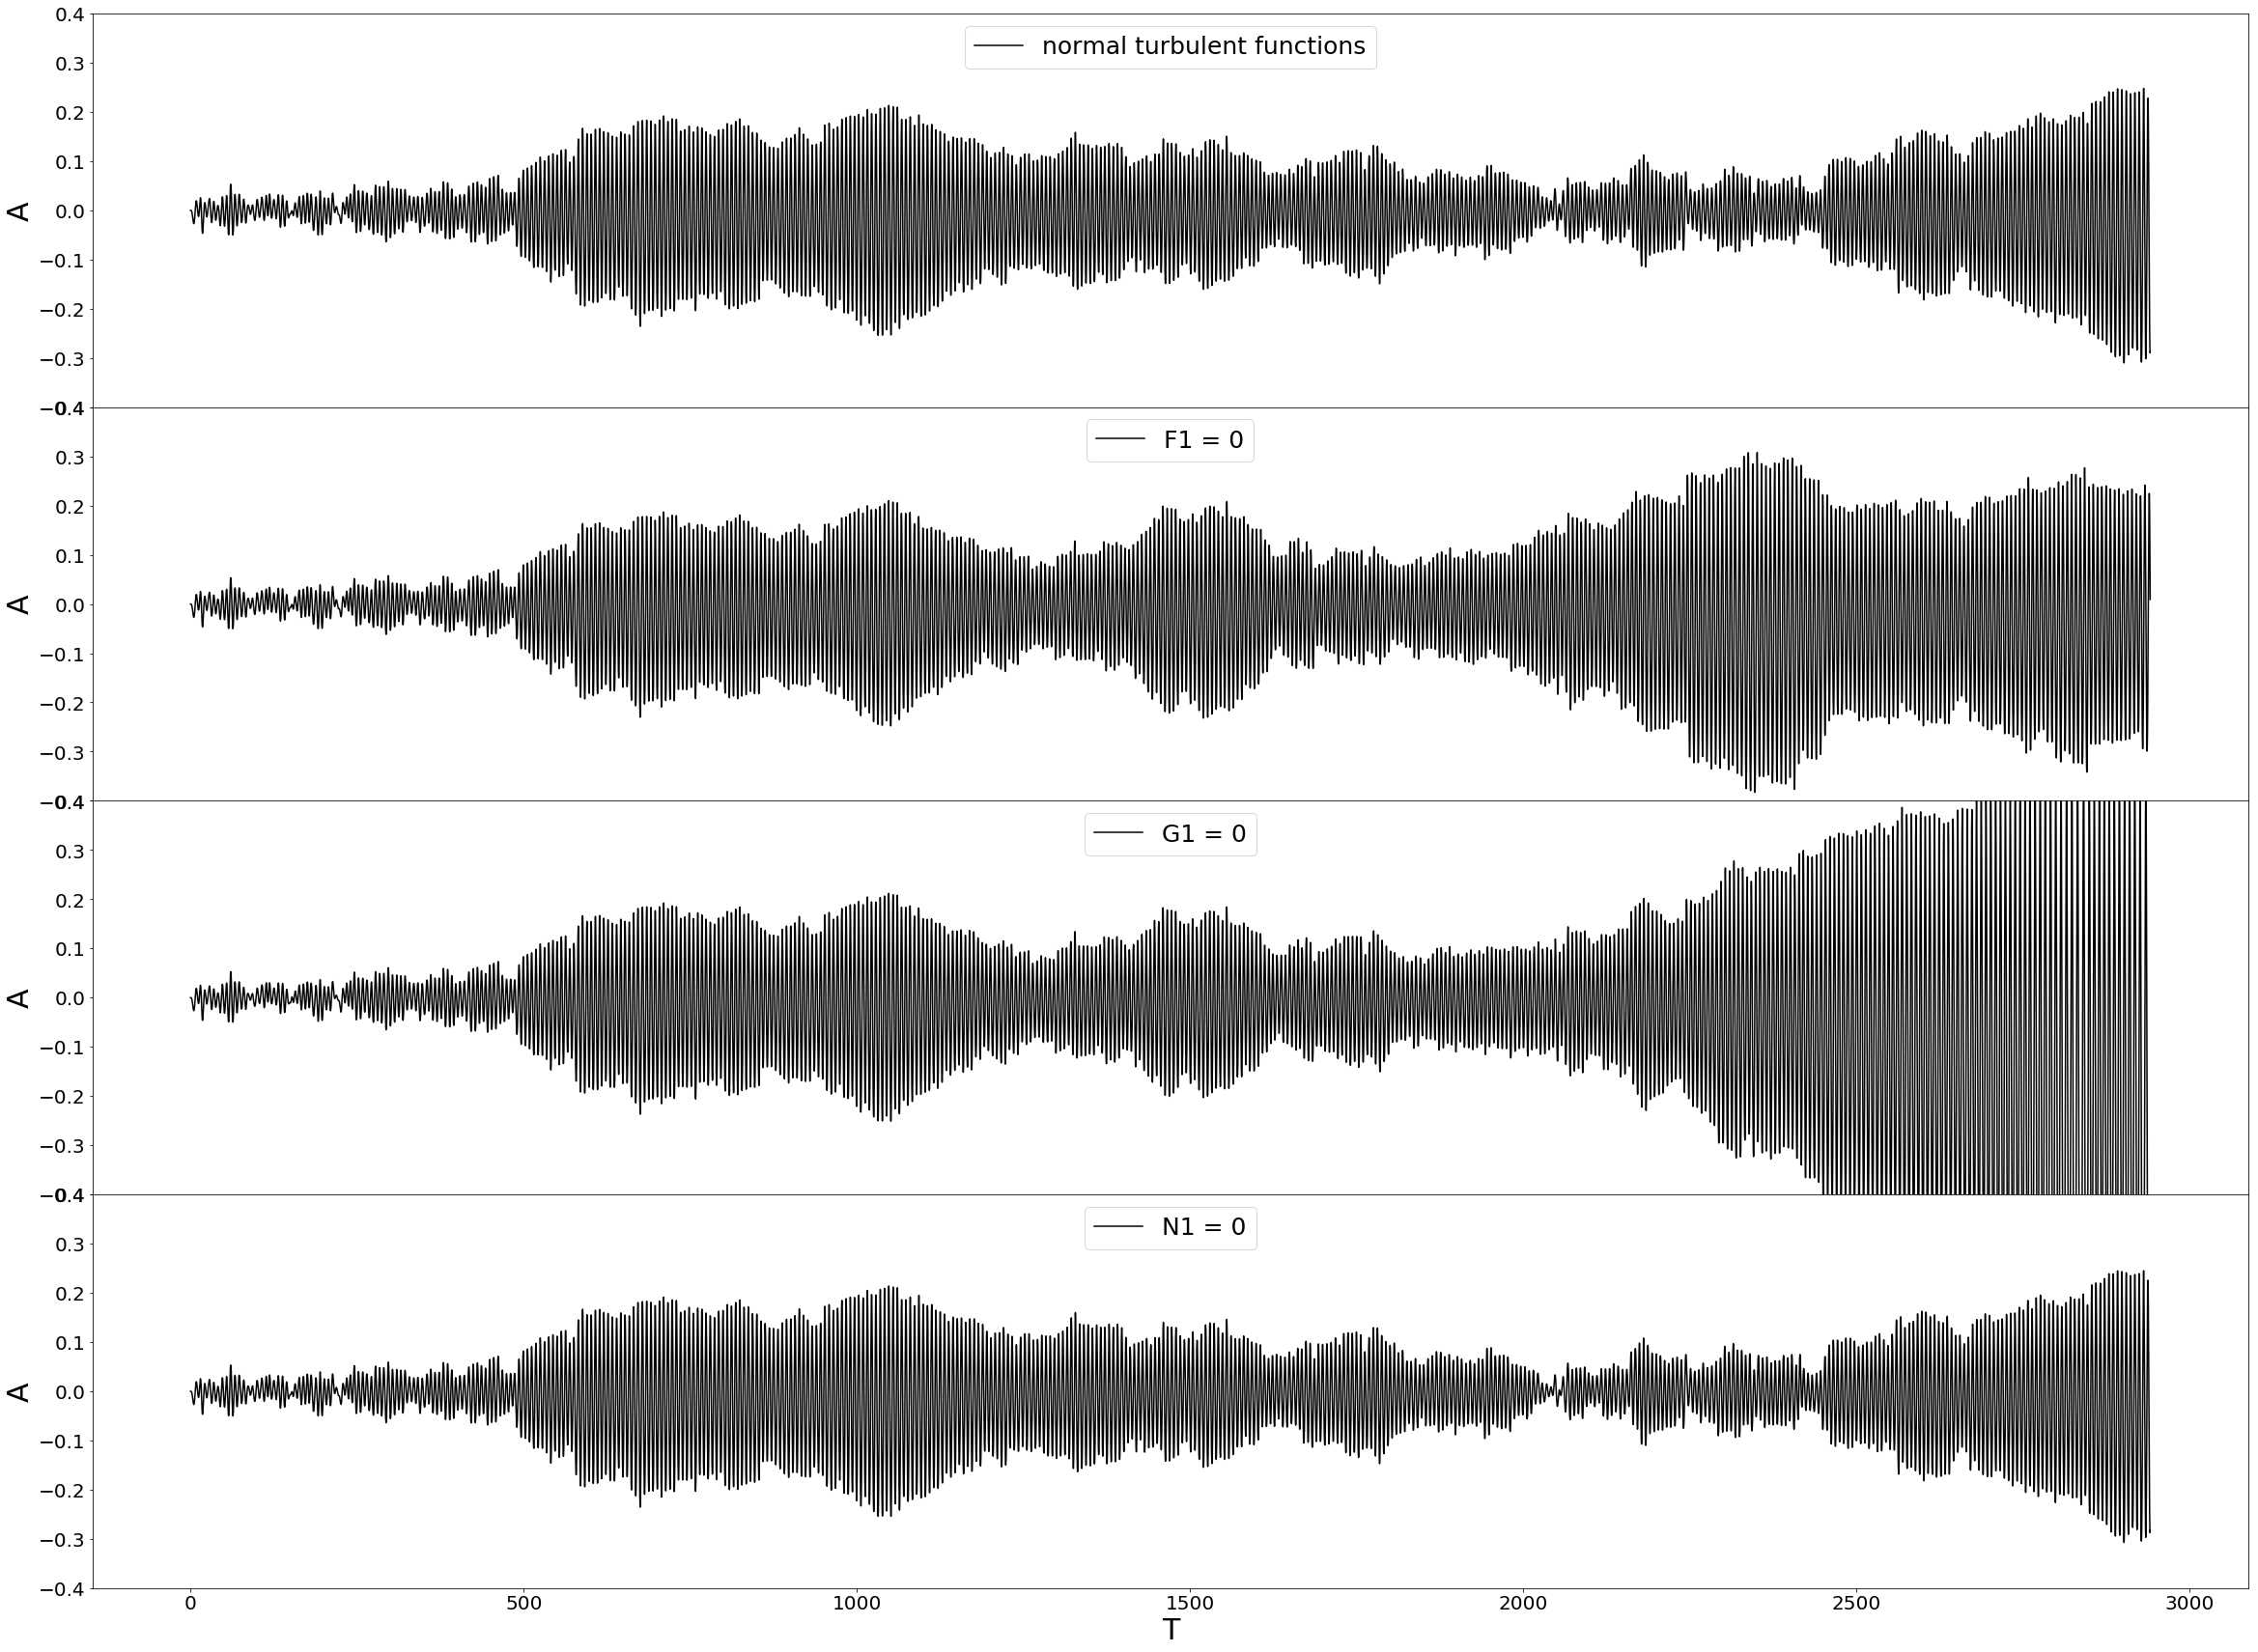

In [43]:
time, A, AF1, AG1, AN1 = funShort(Amp, AmpF1, AmpG1, AmpN1, amptime)
FunplotAmp(time, A, AF1, AG1, AN1)

# Run 4

In [59]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1, N1
F1 = fundHdt(stdF2, limitY2, deltaT, eqmean)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean)
G1 = funF_k(stdF2, limitY2, deltaT, eqmean)
N1 = funF_k(stdF2, limitY2, deltaT, eqmean)

zero = [0 for i in range(len(N1))]

In [60]:
N0 = 1

# normal turbulent functions
Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# F1 = 0
AmpF1, amptimeF1 = funNLAmp(zero, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1)
# G1 = 0
AmpG1, amptimeG1 = funNLAmp(F1, F2, zero, dTau, initial_AT, initial_dAdT, N0, N1)
# N1 = 0
AmpN1, amptimeN1 = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, zero)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
print("Blow out time for each run")
print("Normal turbulent functions: T = ", amptime[-1])
print("F1 = 0: T = ", amptimeF1[-1])
print("G1 = 0: T = ", amptimeG1[-1])
print("N1 = 0: T = ", amptimeN1[-1])

Blow out time for each run
Normal turbulent functions: T =  2217.1475993452314
F1 = 0: T =  4963.779224519643
G1 = 0: T =  2264.8998076796906
N1 = 0: T =  3515.3793475118073


### before normal turbulent function blowout

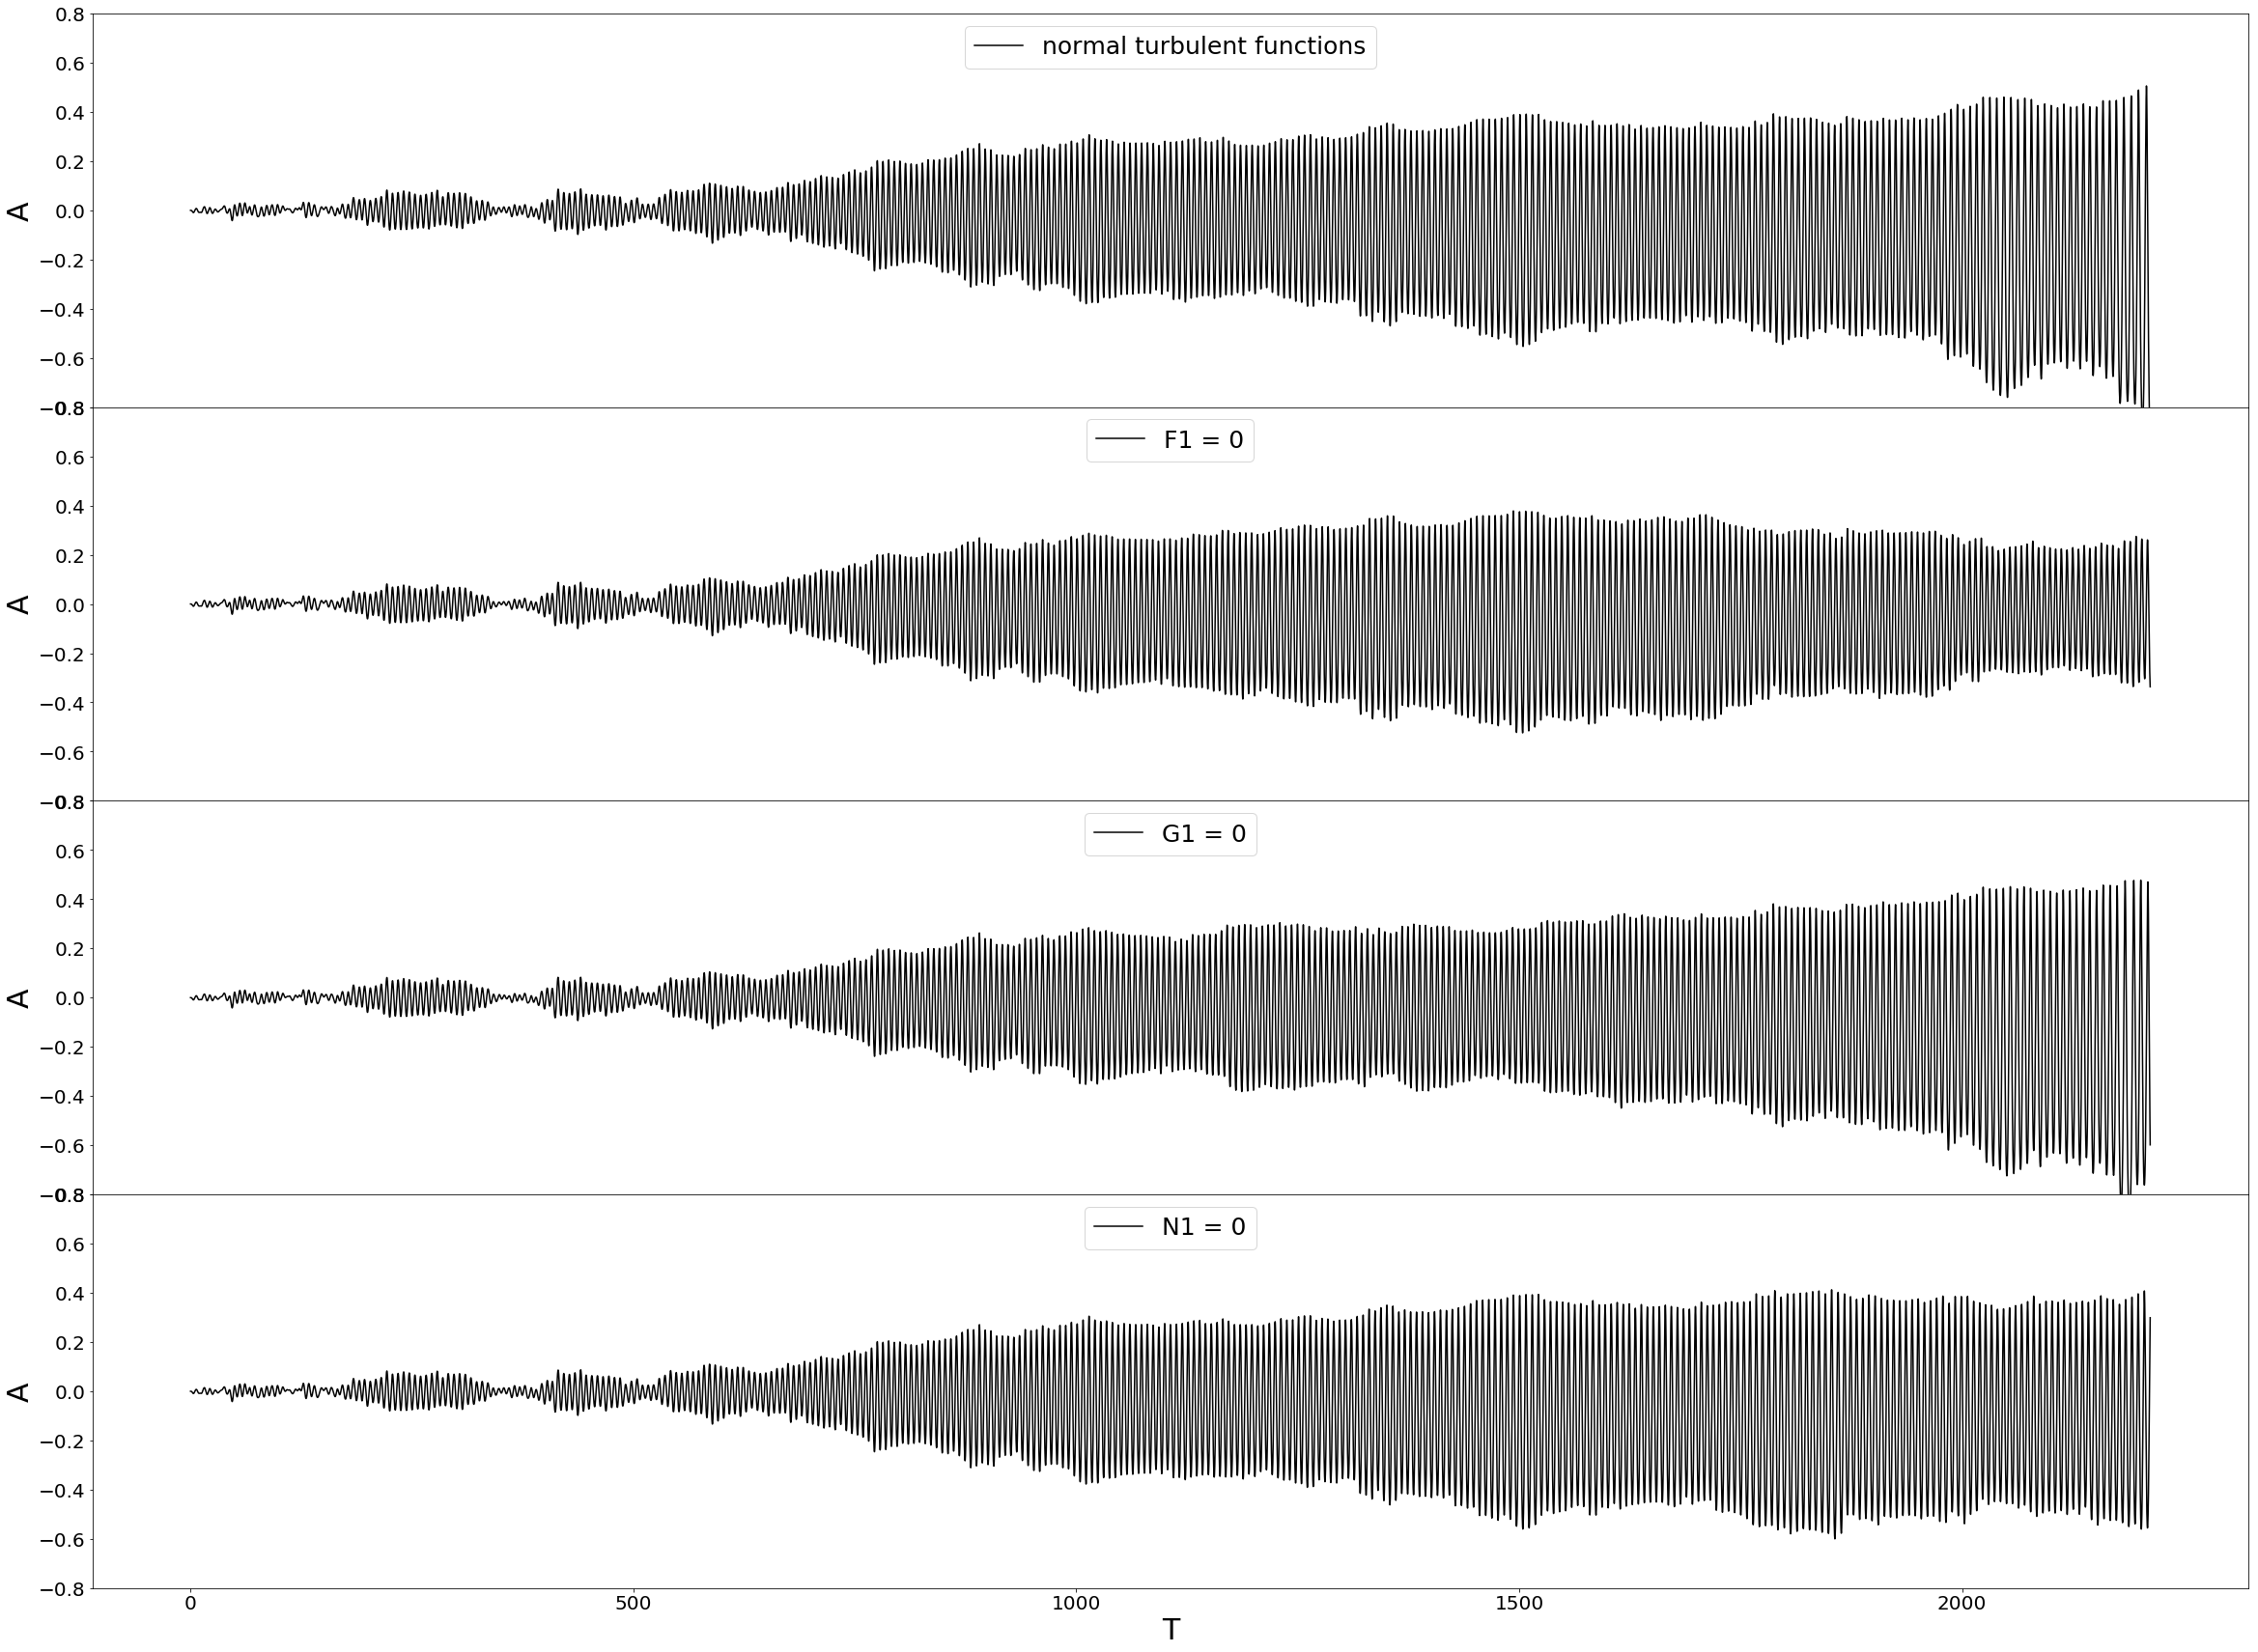

In [67]:
time, A, AF1, AG1, AN1 = funShort(Amp, AmpF1, AmpG1, AmpN1, amptime)
FunplotAmp(time, A, AF1, AG1, AN1)